In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import pandas as pd
from chainconsumer import ChainConsumer
from sbi_lens.config import config_lsst_y_10

In [2]:
# plot params

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["lines.linewidth"] = 1
plt.rcParams['lines.markersize'] = 3
color = [
   '#f8c471',
    '#d68910',
    '#cd6155',
    '#edbb99',
    '#5d6d7e',
    '#73c6b6',
    '#a3b899'
]

In [3]:
from sbi_lens.config import config_lsst_y_10

params_name = config_lsst_y_10.params_name_latex
truth = config_lsst_y_10.truth

In [4]:
sample_ff = jnp.load(
    "/linkhome/rech/genkqu01/ufa23yn/sbi_lens/sbi_lens/data/posterior_full_field__256N_10ms_27gpa_0.26se.npy"
)

mean_truth = jnp.mean(sample_ff, axis = 0)
std_truth = jnp.std(sample_ff, axis = 0)

In [5]:
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams['lines.markersize'] = 7
colmap=['#cd6155', '#5d6d7e', '#a3b899']

total_steps = 70_000
n_flow_layers = 4
n_bijector_layers = 2
activ_fun = 'silu'
proposal = 'prior'
sbi_method  = 'nle'
lr_schedule = 'exp_decay'
nf = 'affine'
bacth_size = 128
seed=3


info_setup = [
    ['unmarginal', 0.0, 0.0]
]

metric_mean = {}
metric_std = {}
sim = {}
for info in info_setup:

    score, score_noise, score_weight = info

    posterior_mean_mean_store = []
    posterior_mean_std_store = []
    posterior_std_mean_store = []
    posterior_std_std_store = []

    for nb_simulations_allow in [100,200,300,400,600,800,1000,1500,2000]:
        
        posterior_mean = []
        posterior_std = []
        count = 0
        for seed in [1,2,3,4,5,6, 111]:
            exp_id = "exp_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                sbi_method,
                total_steps,
                nb_simulations_allow,
                seed,
                n_flow_layers,
                n_bijector_layers,
                activ_fun,
                nf,
                bacth_size,
                score_weight,
                score,
                score_noise,
            )
            posterior = np.load('../results/experiments/{}/posteriors_sample.npy'.format(exp_id))
            if posterior.size != 0:
                count +=1
                # print(posterior[:100_000].shape)
                posterior_mean.append(jnp.mean(posterior, axis =0))
                posterior_std.append(jnp.std(posterior, axis = 0))
        # print(count)
        posterior_mean_mean_store.append(jnp.mean(jnp.array(posterior_mean), axis = 0))
        posterior_mean_std_store.append(jnp.std(jnp.array(posterior_mean), axis = 0))
        posterior_std_mean_store.append(jnp.mean(jnp.array(posterior_std), axis = 0))
        posterior_std_std_store.append(jnp.std(jnp.array(posterior_std), axis = 0))

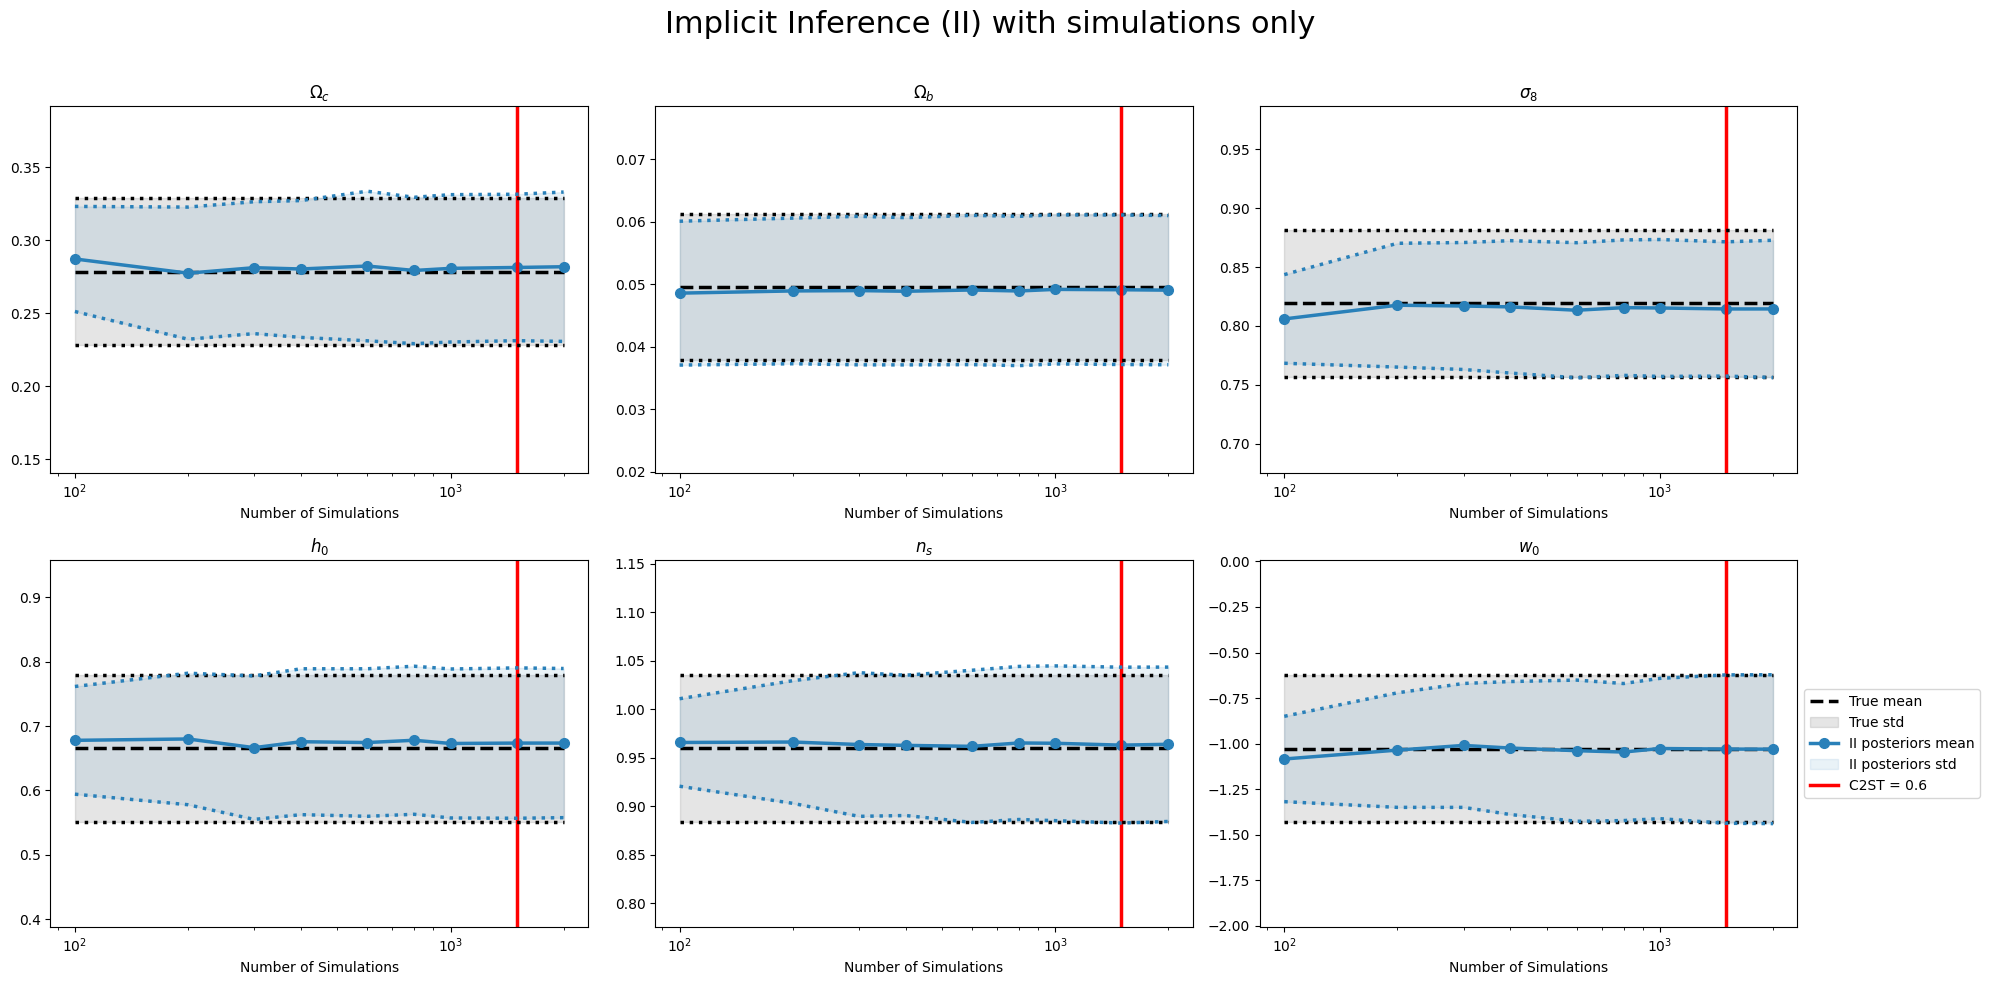

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))  # Adjusted figsize to accommodate two rows
simu_budget = jnp.array([100,200,300,400,600,800,1000,1500,2000])
 # List to store legend labels
t = 2
for i in range(6):
    legend_labels = []
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns
    plt.plot(simu_budget, np.array(mean_truth)[i] * jnp.ones(len(simu_budget)), '--', color='black')
    plt.fill_between(
        simu_budget,
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        alpha=0.1, 
        color='black'
    )
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:, i], color='#2980B9', marker='o')
    plt.fill_between(
        simu_budget,
        np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], 
        np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], 
        alpha=0.1, 
        color='#2980B9'
    )
    plt.axvline(x=1500, color='red')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], ':', color='#2980B9')
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], ':', color='#2980B9')
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.ylim(truth[i] - 5 * np.std(sample_ff[:,i]), truth[i] + 5 * np.std(sample_ff[:,i])) 
    plt.xlabel('Number of Simulations')
    plt.title(params_name[i])  # Adding subplot title
    
    # Append labels to the legend_labels list
    legend_labels.append(f'True mean')
    legend_labels.append(f'True std')
    legend_labels.append(f'II posteriors mean')
    legend_labels.append(f'II posteriors std')
    # legend_labels.append(f'II epistemic uncertainty')
    legend_labels.append(f'C2ST = 0.6')


# Plot a single legend on the right
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle("Implicit Inference (II) with simulations only \n", size=22)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('mean_and_convergence_ii_unmarginal.pdf', transparent = True)

In [7]:
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams['lines.markersize'] = 7
colmap=['#cd6155', '#5d6d7e', '#a3b899']

total_steps = 70_000
n_flow_layers = 4
n_bijector_layers = 2
activ_fun = 'silu'
proposal = 'prior'
sbi_method  = 'nle'
lr_schedule = 'exp_decay'
nf = 'affine'
bacth_size = 128
seed=3


info_setup = [
    ['unmarginal', 0.0, 1e-5]
]

metric_mean = {}
metric_std = {}
sim = {}
for info in info_setup:

    score, score_noise, score_weight = info

    posterior_mean_mean_store = []
    posterior_mean_std_store = []
    posterior_std_mean_store = []
    posterior_std_std_store = []

    for nb_simulations_allow in [100,200,300,400,600,800,1000,1500,2000]:
        
        posterior_mean = []
        posterior_std = []
        count = 0
        for seed in [1,2,3,4,5,6, 111]:
            exp_id = "exp_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                sbi_method,
                total_steps,
                nb_simulations_allow,
                seed,
                n_flow_layers,
                n_bijector_layers,
                activ_fun,
                nf,
                bacth_size,
                score_weight,
                score,
                score_noise,
            )
            posterior = np.load('../results/experiments/{}/posteriors_sample.npy'.format(exp_id))
            if posterior.size != 0:
                count +=1
                # print(posterior[:100_000].shape)
                posterior_mean.append(jnp.mean(posterior, axis =0))
                posterior_std.append(jnp.std(posterior, axis = 0))
        # print(count)
        posterior_mean_mean_store.append(jnp.mean(jnp.array(posterior_mean), axis = 0))
        posterior_mean_std_store.append(jnp.std(jnp.array(posterior_mean), axis = 0))
        posterior_std_mean_store.append(jnp.mean(jnp.array(posterior_std), axis = 0))
        posterior_std_std_store.append(jnp.std(jnp.array(posterior_std), axis = 0))

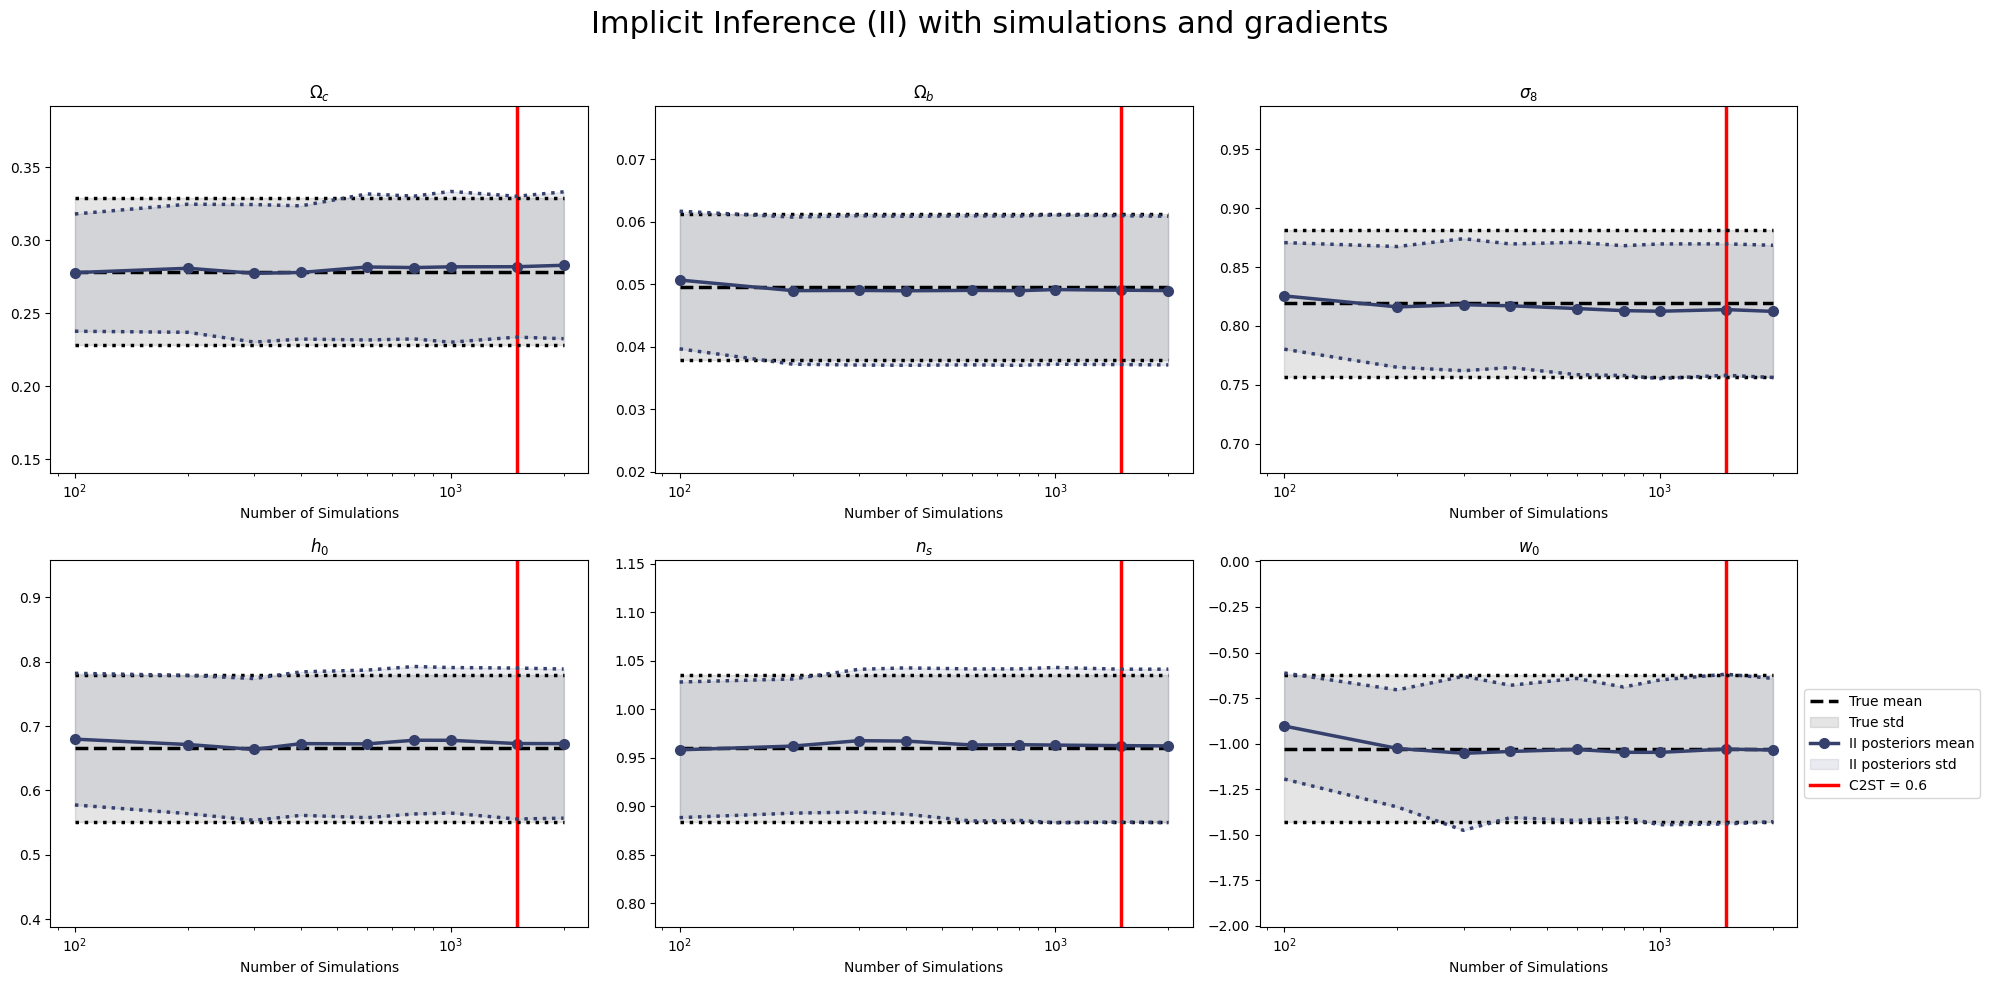

In [8]:
import matplotlib.pyplot as plt
import numpy as np
col = [0.20957247, 0.2515565 , 0.42517886, 1.        ]
plt.figure(figsize=(20, 10))  # Adjusted figsize to accommodate two rows
simu_budget = jnp.array([100,200,300,400,600,800,1000,1500,2000])
 # List to store legend labels
t = 2
for i in range(6):
    legend_labels = []
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns
    plt.plot(simu_budget, np.array(mean_truth)[i] * jnp.ones(len(simu_budget)), '--', color='black')
    plt.fill_between(
        simu_budget,
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        alpha=0.1, 
        color='black'
    )
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:, i], color=col, marker='o')
    plt.fill_between(
        simu_budget,
        np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], 
        np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], 
        alpha=0.1, 
        color=col
    )

    plt.axvline(x=1500, color='red')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], ':', color=col)
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], ':', color=col)
    # plt.errorbar(1000, np.array(posteior_mean_conv)[:,i], yerr=t*np.array(posterior_std_conv)[:,i], fmt="o", color=color[6], alpha=,.
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.ylim(truth[i] - 5 * np.std(sample_ff[:,i]), truth[i] + 5 * np.std(sample_ff[:,i])) 
    plt.xlabel('Number of Simulations')
    plt.title(params_name[i])  # Adding subplot title
    
    # Append labels to the legend_labels list
    legend_labels.append(f'True mean')
    legend_labels.append(f'True std')
    legend_labels.append(f'II posteriors mean')
    legend_labels.append(f'II posteriors std')
    # legend_labels.append(f'II epistemic uncertainty')
    legend_labels.append(f'C2ST = 0.6')

# Plot a single legend on the right
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle("Implicit Inference (II) with simulations and gradients \n", size=22)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('mean_and_convergence_ii_gradients.pdf', transparent = True)

In [9]:
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams['lines.markersize'] = 7
colmap=['#cd6155', '#5d6d7e', '#a3b899']

total_steps = 70_000
n_flow_layers = 4
n_bijector_layers = 2
activ_fun = 'silu'
proposal = 'prior'
sbi_method  = 'nle'
lr_schedule = 'exp_decay'
nf = 'affine'
bacth_size = 128
seed=3


info_setup = [
    ['marginal', 0.0, 1e-5]
]

metric_mean = {}
metric_std = {}
sim = {}
for info in info_setup:

    score, score_noise, score_weight = info

    posterior_mean_mean_store = []
    posterior_mean_std_store = []
    posterior_std_mean_store = []
    posterior_std_std_store = []

    for nb_simulations_allow in [100,200,300,400,600,800,1000,1500,2000]:
        
        posterior_mean = []
        posterior_std = []
        count = 0
        for seed in [1,2,3,4,5,6]:
            exp_id = "exp_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                sbi_method,
                total_steps,
                nb_simulations_allow,
                seed,
                n_flow_layers,
                n_bijector_layers,
                activ_fun,
                nf,
                bacth_size,
                score_weight,
                score,
                score_noise,
            )
            posterior = np.load('../results/experiments/{}/posteriors_sample.npy'.format(exp_id))
            if posterior.size != 0:
                count +=1
                # print(posterior[:100_000].shape)
                posterior_mean.append(jnp.mean(posterior, axis =0))
                posterior_std.append(jnp.std(posterior, axis = 0))
        # print(count)
        posterior_mean_mean_store.append(jnp.mean(jnp.array(posterior_mean), axis = 0))
        posterior_mean_std_store.append(jnp.std(jnp.array(posterior_mean), axis = 0))
        posterior_std_mean_store.append(jnp.mean(jnp.array(posterior_std), axis = 0))
        posterior_std_std_store.append(jnp.std(jnp.array(posterior_std), axis = 0))

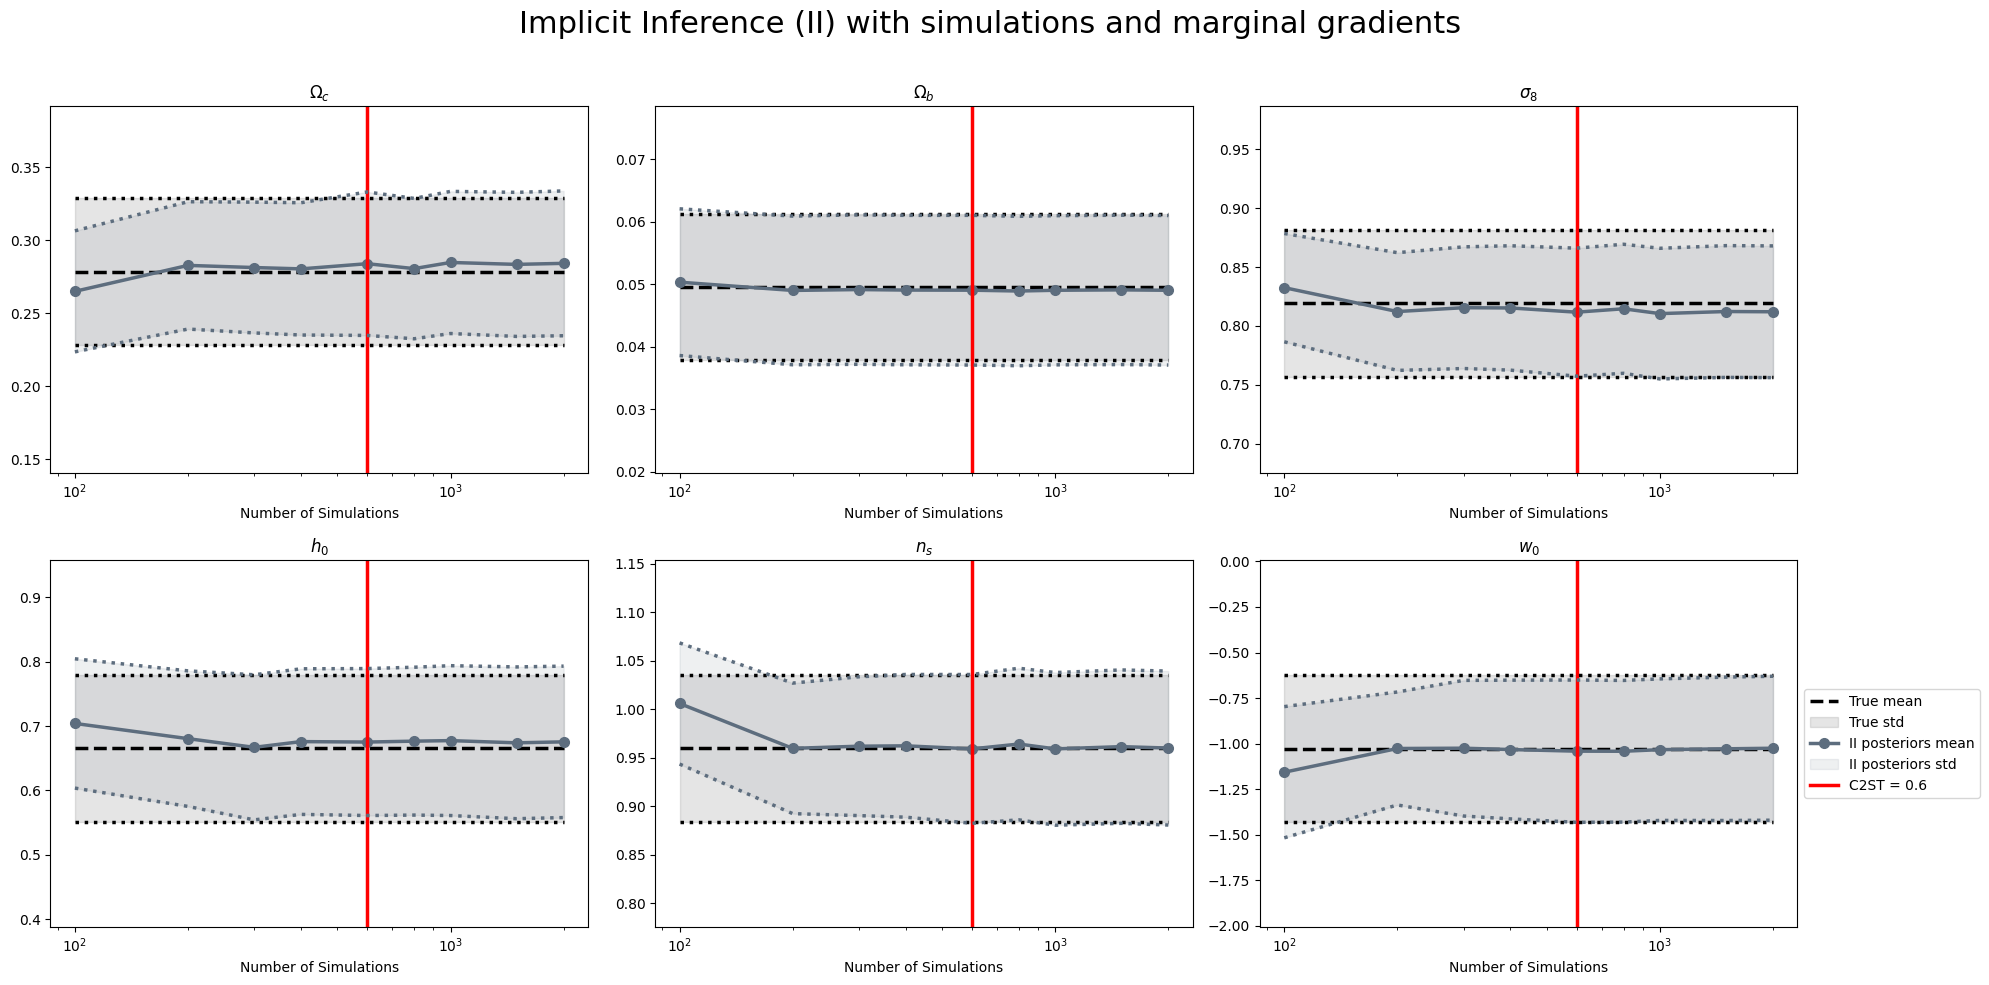

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))  # Adjusted figsize to accommodate two rows
simu_budget = jnp.array([100,200,300,400,600,800,1000,1500,2000])
 # List to store legend labels
t = 2
for i in range(6):
    legend_labels = []
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns
    plt.plot(simu_budget, np.array(mean_truth)[i] * jnp.ones(len(simu_budget)), '--', color='black')
    plt.fill_between(
        simu_budget,
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        alpha=0.1, 
        color='black'
    )
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:, i], color=color[4], marker='o')
    plt.fill_between(
        simu_budget,
        np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], 
        np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], 
        alpha=0.1, 
        color=color[4]
    )

    plt.axvline(x=600, color='red')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], ':', color=color[4])
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], ':', color=color[4])
    # plt.errorbar(1000, np.array(posteior_mean_conv)[:,i], yerr=t*np.array(posterior_std_conv)[:,i], fmt="o", color=color[6], alpha=,.
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.ylim(truth[i] - 5 * np.std(sample_ff[:,i]), truth[i] + 5 * np.std(sample_ff[:,i])) 
    plt.xlabel('Number of Simulations')
    plt.title(params_name[i])  # Adding subplot title
    
    # Append labels to the legend_labels list
    legend_labels.append(f'True mean')
    legend_labels.append(f'True std')
    legend_labels.append(f'II posteriors mean')
    legend_labels.append(f'II posteriors std')
    # legend_labels.append(f'II epistemic uncertainty')
    legend_labels.append(f'C2ST = 0.6')


# Plot a single legend on the right
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle("Implicit Inference (II) with simulations and marginal gradients \n", size=22)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('mean_and_convergence_ii_marginal_gradients.pdf', transparent = True)

In [11]:
import jax.numpy as jnp
from sklearn.neighbors import KernelDensity
import numpy as np
from chainconsumer import ChainConsumer
# from sbi_lens.config import config_lsst_y_10

In [12]:
number_chains = 31
chains = []
for i in range(number_chains):
    posterior = jnp.load(
    '/gpfsdswork/projects/rech/eqw/ufa23yn/dev/lensing_project/paper_sbi_lensing/hmc_becnhmarck/posterior_full_field_job_{}N_256ms_10gpa_27se.npy'.format(i),
    allow_pickle=True
    )
    chains.append(posterior)
    
chains = jnp.array(chains).reshape([-1,6])

In [13]:
simu_budget = jnp.array([200, 400, 600, 1000, 1500, 2000, 3000, 5000, 8_000])
# 100,200,300,400,600,800,1000,1500,2000])
mean_store = []
std_store = []
for i in simu_budget:
    X = chains[:i, :]
    # kde = KernelDensity(kernel='gaussian', bandwidth=1e-3).fit(X)
    # kde_sample = kde.sample(len(chains))
    mean_store.append(jnp.mean(X, axis = 0))
    std_store.append(jnp.std(X, axis = 0))

In [14]:
# inds = np.random.randint(0, len(chains), 10_000)
mean_truth = jnp.mean(sample_ff, axis = 0)
std_truth = jnp.std(sample_ff, axis = 0)

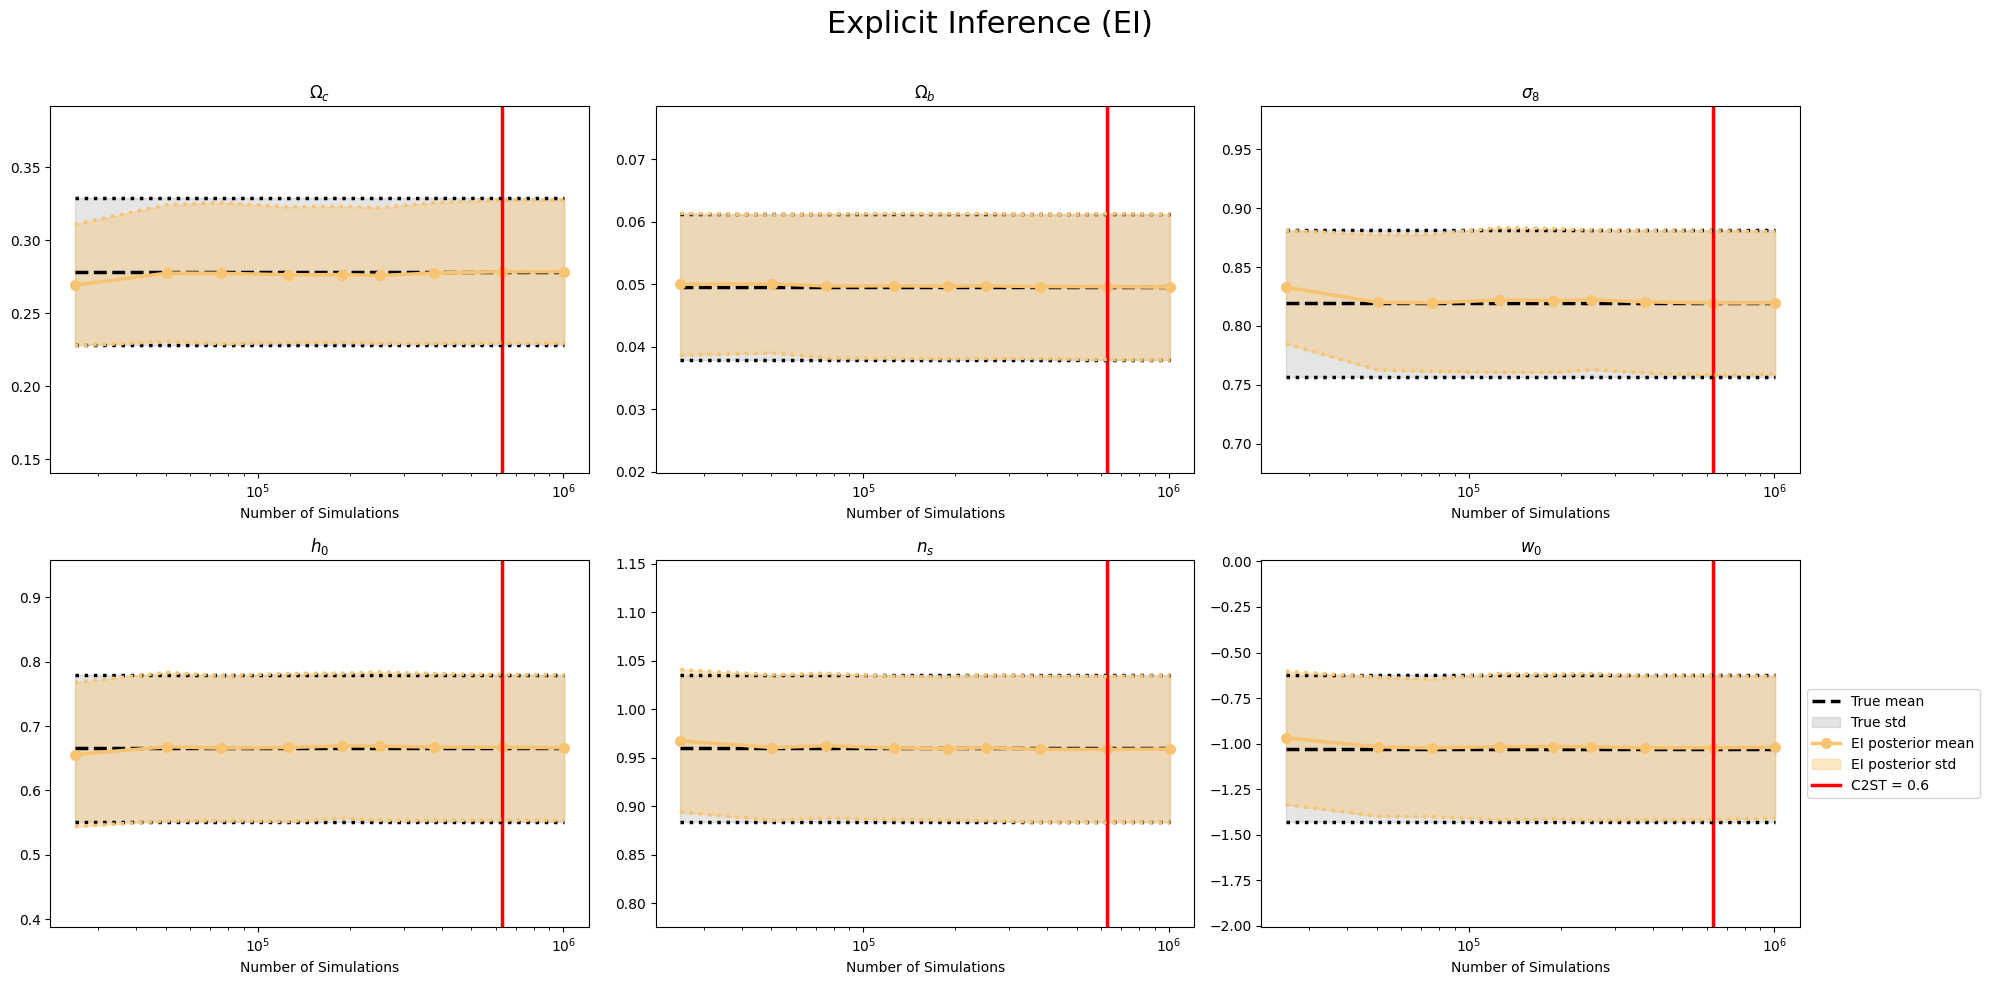

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))  # Adjusted figsize to accommodate two rows
simu_budget = jnp.array([200, 400, 600, 1000, 1500, 2000, 3000, 5000, 8_000])*63*2
 # List to store legend labels
t = 2
for i in range(6):
    legend_labels = []
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns
    plt.plot(simu_budget, np.array(mean_truth)[i] * jnp.ones(len(simu_budget)), '--', color='black')
    plt.fill_between(
        simu_budget,
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        alpha=0.1, 
        color='black'
    )
    plt.plot(simu_budget, np.array(mean_store)[:,i], color=color[0], marker='o')
    # plt.fill_between(
    #     simu_budget,
    #     np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], 
    #     np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], 
    #     alpha=0.1, 
    #     color=color[4]
    # )
    plt.fill_between(
        simu_budget,
        np.array(mean_store)[:,i] - t*np.array(std_store)[:,i], 
        np.array(mean_store)[:,i] + t*np.array(std_store)[:,i], 
        alpha=0.4, 
        color=color[0]
    )
    plt.axvline(x=630_000, color='red')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, np.array(mean_store)[:,i] - t*np.array(std_store)[:,i], ':', color=color[0])
    plt.plot(simu_budget, np.array(mean_store)[:,i] + t*np.array(std_store)[:,i], ':', color=color[0])
    # plt.errorbar(1000, np.array(posteior_mean_conv)[:,i], yerr=t*np.array(posterior_std_conv)[:,i], fmt="o", color=color[6], alpha=,.
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.ylim(truth[i] - 5 * np.std(sample_ff[:,i]), truth[i] + 5 * np.std(sample_ff[:,i])) 
    plt.xlabel('Number of Simulations')
    plt.title(params_name[i])  # Adding subplot title 

    # Append labels to the legend_labels list
    legend_labels.append(f'True mean')
    legend_labels.append(f'True std')
    legend_labels.append(f'EI posterior mean')
    legend_labels.append(f'EI posterior std')
    # legend_labels.append(f'II epistemic uncertainty')
    legend_labels.append(f'C2ST = 0.6')

# Plot a single legend on the right
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle("Explicit Inference (EI) \n", size=22)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('mean_and_convergence_ei.pdf', transparent = True)

In [17]:
# import arviz as az
from chainconsumer import ChainConsumer
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sbi_lens.config import config_lsst_y_10
import numpy as np

import numpy as np
from getdist import plots, MCSamples
import matplotlib.pyplot as plt

params_name = config_lsst_y_10.params_name_latex
truth = config_lsst_y_10.truth
# az.style.use("arviz-white")

sample_ff = jnp.load(
    "/linkhome/rech/genkqu01/ufa23yn/sbi_lens/sbi_lens/data/posterior_full_field__256N_10ms_27gpa_0.26se.npy"
)
mean_truth = jnp.mean(sample_ff, axis = 0)
std_truth = jnp.std(sample_ff, axis = 0)

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams['lines.markersize'] = 7
color = [
   '#f8c471',
    '#d68910',
    '#cd6155',
    '#edbb99',
    '#5d6d7e',
    '#73c6b6',
    '#a3b899'
]

total_steps = 70_000
n_flow_layers = 4
n_bijector_layers = 2
activ_fun = 'silu'
proposal = 'prior'
sbi_method  = 'nle'
lr_schedule = 'exp_decay'
nf = 'affine'
bacth_size = 128
seed=3


info_setup = [
    ['unmarginal', 0.0, 0.0]
]

metric_mean = {}
metric_std = {}
sim = {}
for info in info_setup:

    score, score_noise, score_weight = info

    posterior_mean_mean_store = []
    posterior_mean_std_store = []
    posterior_std_mean_store = []
    posterior_std_std_store = []

    for nb_simulations_allow in [100,200,400,600,1000,2000]:#:]:
        
        posterior_mean = []
        posterior_std = []
        count = 0
        plt.figure()
        g = plots.get_subplot_plotter(width_inch=7, scaling=False)
        g.settings.figure_legend_frame = False
        g.settings.alpha_filled_add=0.4
        g.settings.title_limit_fontsize = 14
        
        param_names = ['omega_c', 'omega_b', '\sigma_8', 'h_0', 'n_s', 'w_0']
        param_labels = [r'\Omega_c', r'\Omega_b', r'\sigma_8', r'h_0', r'n_s', r'w_0']
        
        # Create the MCSamples objects with the labels
        samples = []
        legend = []
        filled = []
        line_args = []
        contour_colors = []
        contour_args = []

        for seed in [1,2,3,4,5,6]:#]:
            exp_id = "exp_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                sbi_method,
                total_steps,
                nb_simulations_allow,
                seed,
                n_flow_layers,
                n_bijector_layers,
                activ_fun,
                nf,
                bacth_size,
                score_weight,
                score,
                score_noise,
            )
            posterior = np.load('../results/experiments/{}/posteriors_sample.npy'.format(exp_id))
            if posterior.size != 0:
                posterior_mean.append(posterior[:10_000])
                samples.append( MCSamples(samples=posterior, names=param_names, labels=param_labels))
                filled.append(False)
                line_args.append({'lw':0.8, 'color':'#2980B9',})
                contour_colors.append('#2980B9')
                contour_args.append({'lw':0.8, })

                if len(posterior_mean)==1:  #just for labels purposes
                    legend.append(f'II with {nb_simulations_allow} simulations')
                    samples.append(MCSamples(samples=sample_ff, names=param_names, labels=param_labels))
                    legend.append('Ground truth')
                    filled.append(True)
                    line_args.append({'lw':2, 'color':'#1B2631',})
                    contour_colors.append('#1B2631')
                    contour_args.append({'lw':2, })
   
        g.triangle_plot(
            samples,
            params=param_names,# Add parameter names here
            filled=filled,
            legend_labels=legend, 
            legend_loc='upper right',
            line_args=line_args,
            contour_colors=contour_colors,
            contour_args=contour_args,
        )
        mean_spoterior = jnp.mean(jnp.array(posterior_mean).reshape([-1,6]), axis = 0)

        axes = g.subplots.reshape((6, 6))
        for i in range(6):
            for j in range(i):
                ax = axes[i, j]
                ax.plot(mean_spoterior[j], mean_spoterior[i], marker='+', 
                     markeredgecolor='#f8c471', markersize=10, mew=2)
                ax.plot(mean_truth[j], mean_truth[i], marker='+', 
                     markeredgecolor='#1B2631', markersize=10, mew=2)
    
        # Create custom legend handles for the mean markers
        from matplotlib.lines import Line2D
        custom_lines = [Line2D([0], [0], color='#1B2631', marker='+', markersize=10, mew=2, linestyle='None', markeredgecolor='#1B2631'),
                        Line2D([0], [0], color='#f8c471', marker='+', markersize=10, mew=2, linestyle='None', markeredgecolor='#f8c471')]
    
        # Add the custom legend below the existing legend
        plt.legend(custom_lines, ['True mean', 'Mean of II posteriors'], loc='upper right', bbox_to_anchor=(0.7,5.5),frameon=False, fontsize=12)
    
        g.export(f'contourplot_{nb_simulations_allow}_simu.pdf')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/tmp/ipykernel_1511239/3780136310.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
